In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


C:\Users\Apoorv Bagga\AppData\Roaming\Python\Python310\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)


100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [00:16<00:00, 10.1MB/s]


In [4]:
class EncoderDecoderCNN(nn.Module):
    def __init__(self):
        super(EncoderDecoderCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
print("Encoder-Decoder CNN Model Defined:")

Encoder-Decoder CNN Model Defined:


In [5]:
model = EncoderDecoderCNN().to(device)

mse_loss_fn = nn.MSELoss()
l1_loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.0002)


In [6]:
epochs = 30

mse_losses = []
l1_losses = []

for epoch in range(epochs):
    total_mse = 0.0
    total_l1 = 0.0

    for images, _ in train_loader:
        images = images.to(device)

        outputs = model(images)

        mse_loss = mse_loss_fn(outputs, images)
        l1_loss = l1_loss_fn(outputs, images)

        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

        total_mse += mse_loss.item()
        total_l1 += l1_loss.item()

    avg_mse = total_mse / len(train_loader)
    avg_l1 = total_l1 / len(train_loader)

    mse_losses.append(avg_mse)
    l1_losses.append(avg_l1)

    print(f"Epoch [{epoch+1}/{epochs}] | MSE Loss: {avg_mse:.4f} | L1 Loss: {avg_l1:.4f}")


Epoch [1/30] | MSE Loss: 0.0187 | L1 Loss: 0.0879
Epoch [2/30] | MSE Loss: 0.0043 | L1 Loss: 0.0480
Epoch [3/30] | MSE Loss: 0.0029 | L1 Loss: 0.0394
Epoch [4/30] | MSE Loss: 0.0023 | L1 Loss: 0.0344
Epoch [5/30] | MSE Loss: 0.0019 | L1 Loss: 0.0311
Epoch [6/30] | MSE Loss: 0.0016 | L1 Loss: 0.0286
Epoch [7/30] | MSE Loss: 0.0014 | L1 Loss: 0.0265
Epoch [8/30] | MSE Loss: 0.0012 | L1 Loss: 0.0246
Epoch [9/30] | MSE Loss: 0.0011 | L1 Loss: 0.0232
Epoch [10/30] | MSE Loss: 0.0010 | L1 Loss: 0.0219
Epoch [11/30] | MSE Loss: 0.0009 | L1 Loss: 0.0208
Epoch [12/30] | MSE Loss: 0.0008 | L1 Loss: 0.0198
Epoch [13/30] | MSE Loss: 0.0007 | L1 Loss: 0.0191
Epoch [14/30] | MSE Loss: 0.0007 | L1 Loss: 0.0183
Epoch [15/30] | MSE Loss: 0.0006 | L1 Loss: 0.0177
Epoch [16/30] | MSE Loss: 0.0006 | L1 Loss: 0.0172
Epoch [17/30] | MSE Loss: 0.0006 | L1 Loss: 0.0168
Epoch [18/30] | MSE Loss: 0.0005 | L1 Loss: 0.0163
Epoch [19/30] | MSE Loss: 0.0005 | L1 Loss: 0.0158
Epoch [20/30] | MSE Loss: 0.0005 | L1 Lo

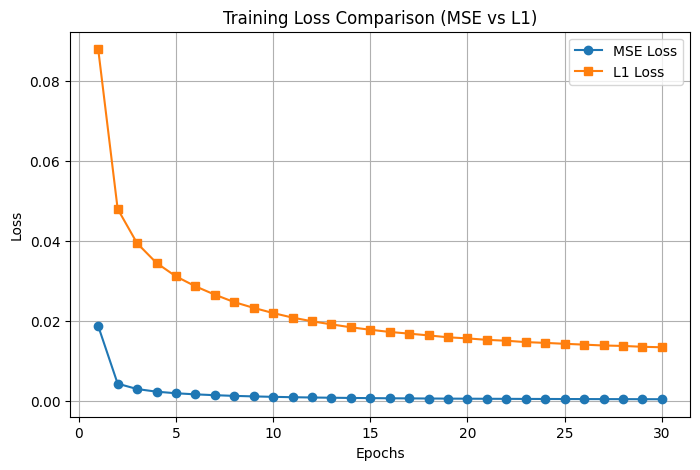

In [7]:
plt.figure(figsize=(8,5))

plt.plot(range(1, epochs+1), mse_losses, label="MSE Loss", marker='o')
plt.plot(range(1, epochs+1), l1_losses, label="L1 Loss", marker='s')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (MSE vs L1)")
plt.legend()
plt.grid(True)

plt.show()


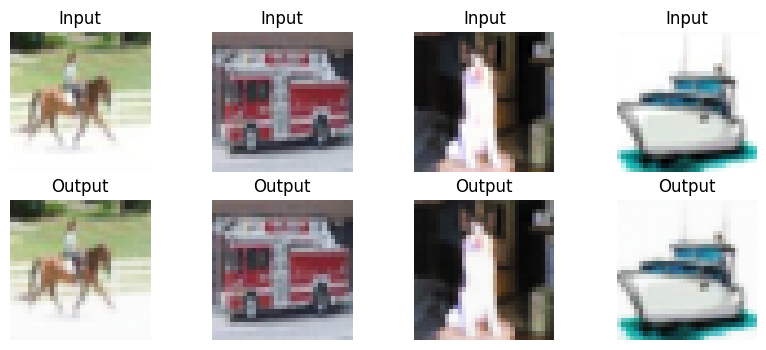

In [8]:
def denormalize(img):
    return (img + 1) / 2

model.eval()
images, _ = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

images = denormalize(images.cpu())
outputs = denormalize(outputs.cpu())

plt.figure(figsize=(10,4))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title("Input")
    plt.axis("off")

    plt.subplot(2, 4, i+5)
    plt.imshow(outputs[i].permute(1,2,0))
    plt.title("Output")
    plt.axis("off")

plt.show()


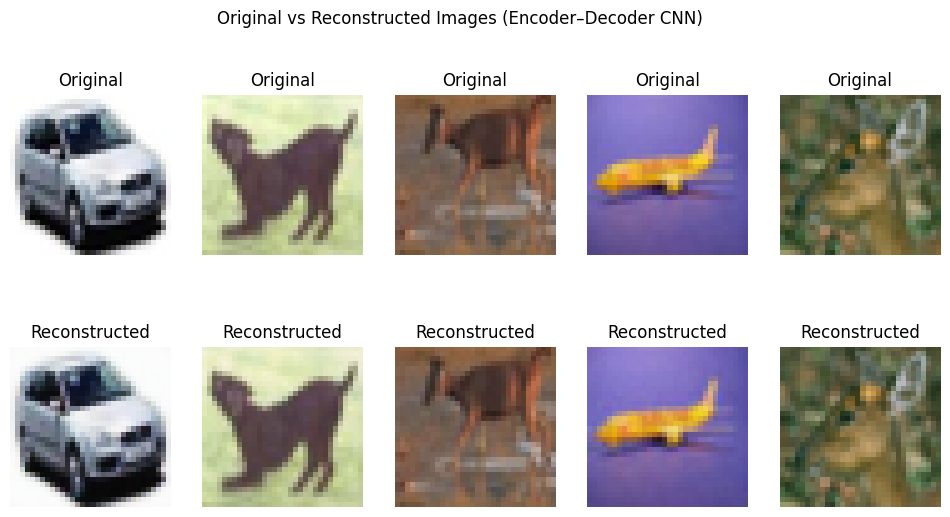

In [9]:
import matplotlib.pyplot as plt

def denormalize(img):
    return (img + 1) / 2   # [-1,1] → [0,1]

model.eval()

# Get a batch of images
images, _ = next(iter(train_loader))
images = images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructed = model(images)

# Move to CPU and denormalize
images = denormalize(images.cpu())
reconstructed = denormalize(reconstructed.cpu())

# Plot
plt.figure(figsize=(12,6))

for i in range(5):
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i].permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("Original vs Reconstructed Images (Encoder–Decoder CNN)")
plt.show()


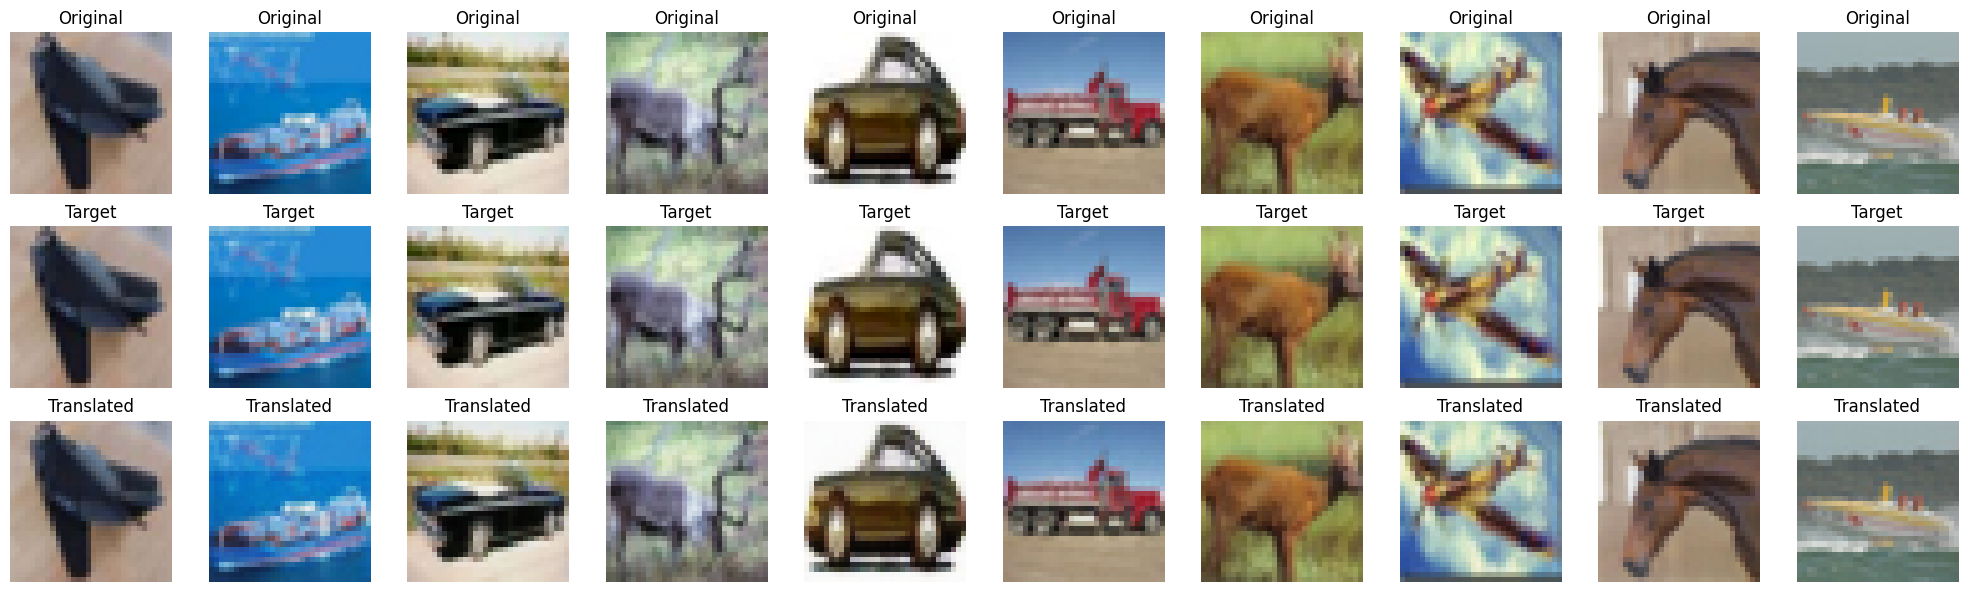

In [10]:
import matplotlib.pyplot as plt

def denormalize(img):
    return (img + 1) / 2   # [-1,1] → [0,1]

model.eval()

# Take one batch
images, _ = next(iter(train_loader))
images = images.to(device)

# Since this is reconstruction:
targets = images.clone()

# Generate translated (reconstructed) images
with torch.no_grad():
    translated = model(images)

# Move to CPU and denormalize
images = denormalize(images.cpu())
targets = denormalize(targets.cpu())
translated = denormalize(translated.cpu())

num_images = 10  # number of columns

plt.figure(figsize=(20, 6))

for i in range(num_images):

    # ---------- Original ----------
    plt.subplot(3, num_images, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # ---------- Target ----------
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(targets[i].permute(1, 2, 0))
    plt.title("Target")
    plt.axis("off")

    # ---------- Translated ----------
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(translated[i].permute(1, 2, 0))
    plt.title("Translated")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
print(images.min(), images.max())


tensor(0.) tensor(1.)
